## To do

1. Process data to be in format of (batch_size, frames_length, frame_size*frame_size)
2. Build RNN model
    * RNN cell: 1 layer, identity matrix initialization, relu activation
    * FC linear layer
    * Start with building single-shot model, then work up to autoregressive model
      * Single-shot    = 7 inputs, 1 output
      * Autoregressive = warmup... 1 input, 1 output repeatedly fed into model
3. Train model
4. Visualise weights
    * Input weights
    * Spike triggered averaging
    
    
## Data format
    input = [0, 1, 2, ... WARMUP]
    targets = [WARMUP+1, WARMUP+2, ... WARMUP+T_STEPS+1]

In [177]:
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

WARMUP = 20
T_STEPS = 8
FRAME_SIZE = 20

In [224]:
class FramesDataset (torch.utils.data.Dataset):
    def __init__ (self, path, split_type):
        with open(path, 'rb') as file:
            dataset = pickle.load(file)

        n = len(dataset)
        splits = {
            "train": slice(0, int(n*0.8)),
            "val": slice(int(n*0.8), int(n*0.9)),
            "test": slice(int(n*0.9), None)
        }

        dataset = dataset[splits[split_type]]
        reordered = []
        for example in dataset:
            frames = []
            for i in range(example.shape[-1]):
                frame = example[:, :, i]
                frames.append(frame.flatten())
            reordered.append(frames)
                             
        self.dataset = torch.from_numpy(np.array(reordered))
        self.dataset = self.dataset.type(torch.FloatTensor)
    def __len__ (self):
        return len(self.dataset)
    def __getitem__ (self, i):
        window = self.dataset[i]
        x = window[:WARMUP, :]
        y = window[WARMUP:, :]

        return x, y

train_dataset = FramesDataset('./processed_dataset.pkl', 'train')
val_dataset = FramesDataset('./processed_dataset.pkl', 'val')

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)

(20, 200)


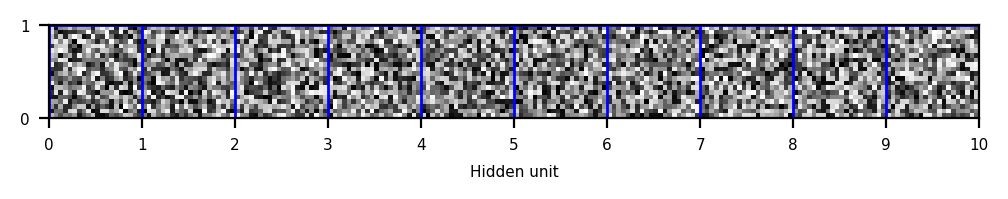

In [295]:
class RNN_Network (nn.Module):
    def __init__ (self, hidden_units):
        super(RNN_Network, self).__init__()
        
        self.hidden_units = hidden_units
        
        self.rnn = nn.RNNCell(
            input_size = FRAME_SIZE**2,
            hidden_size = hidden_units,
            nonlinearity = 'relu'
        )     
        self.fc = nn.Linear(hidden_units, FRAME_SIZE**2)
        
        # Initialise RNN weights with identity matrix
        self.rnn.weight_hh = torch.nn.Parameter(torch.eye(hidden_units, hidden_units)) 
    def forward (self, inputs):
        predictions = []
        hidden_state = torch.zeros((inputs.shape[0], self.hidden_units))
        
        # Warm up period
        for i in range(WARMUP):
            frame_batch = inputs[:, i, :]
            hidden_state = self.rnn(frame_batch, hidden_state)
        prediction = self.fc(hidden_state)
        predictions.append(prediction)

        # Autoregressive predictions
        for t in range(T_STEPS):
            hidden_state = self.rnn(prediction, hidden_state)
            prediction = self.fc(hidden_state)
            predictions.append(prediction)
            
        return torch.transpose(torch.stack(predictions), 0, 1)
    
def L1_regularisation (lam, loss, model):
    weights = torch.Tensor([])
    for name, params in model.named_parameters():
        if name.endswith('weight'):
            weights = torch.cat((weights, params.flatten()), 0)
    
    return loss + lam*weights.abs().sum()

def plot_input_weights (model, hidden_units, title=""):
    weights = model.rnn.weight_ih.cpu().detach().numpy()    
    weights = np.reshape(weights[:hidden_units, :], (FRAME_SIZE, FRAME_SIZE*hidden_units))
    
    print(weights.shape)
    
    font_size = 5.5
    font_size_title = 6
    
    fig, ax = plt.subplots(dpi=200)
    ax.imshow(weights, extent=[0, hidden_units, 0, 1], cmap='gray')
    
    ax.set_xticks(np.arange(0, hidden_units+1))
    ax.set_xticklabels(np.arange(0, hidden_units+1), size=font_size)
    ax.set_xlabel('Hidden unit', size=font_size)
    
    ax.set_yticks(np.arange(0, 2))
    ax.set_yticklabels(np.arange(0, 2), size=font_size)    
    
    ax.grid(which='major', color='b', linestyle='-', linewidth=1)
    ax.set_title(title, size=font_size_title)

In [ ]:
model = RNN_Network(hidden_units = 100)

n_epochs = 100
lr=0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, n_epochs + 1):
    for batch_n, data in enumerate(train_data_loader):
        inputs, targets = data
    
        optimizer.zero_grad()
        output = model(inputs)
        loss = L1_regularisation(10e-6, criterion(output, targets), model)
        loss.backward()
        nn.utils.clip_grad_value_(net.parameters(), clip_value=1.0)  #Gradient Value Clipping
        optimizer.step()

    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Loss: {:.4f}".format(loss.item()))
    
plot_input_weights(model, hidden_units = 10)

Epoch: 1/100............. Loss: 3.2773
Epoch: 2/100............. Loss: 2.6147
Epoch: 3/100............. Loss: 2.2837
Epoch: 4/100............. Loss: 2.0784
Epoch: 5/100............. Loss: 1.9360
Epoch: 6/100............. Loss: 1.8298


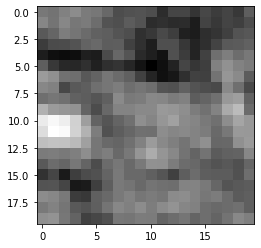

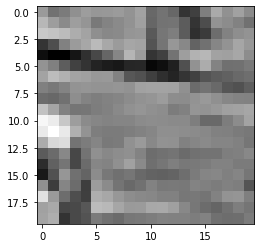

In [222]:
x, y = train_dataset[0]
pred = torch.squeeze(model(torch.unsqueeze(x, 0)), 0)

n = 8

im_pred = pred[n].view(20, 20).detach().numpy()
im_y = y[n].view(20, 20).detach().numpy()

plt.imshow(im_pred, cmap='gray')
plt.show()
plt.imshow(im_y, cmap='gray')